Imports

In [13]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import compat_sac
from compat_sac import TwoTensorReset
from stable_baselines3.common.vec_env import DummyVecEnv
import gym

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

# Sodt Actor Critic codes from OpenAI for trajefctory generation
from stable_baselines3 import SAC
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy as evaluate_policy_sac


# If the Box class doesn’t already pretend to have `.n`,
# give it one that returns the action dimension.
if not hasattr(gym.spaces.Box, "n"):
    gym.spaces.Box.n = property(lambda self: self.shape[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Our functions

In [14]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies
from PPO import ppo_update, RolloutBuffer, evaluate_policy

# Training loop for SAC
from PPO_Fla import *
from pairs_generator import sample_preference_pairs

#Redefinition to avoid conflict with SAC
from DPO import DPO_training_sac as DPO_training
from Pendulum_functions import compute_logprob_trajectory_sac as compute_logprob_trajectory




beta by default 0.5


Creating policies and changing seeds:

C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.


Evaluations over 100 episodes done for both policies


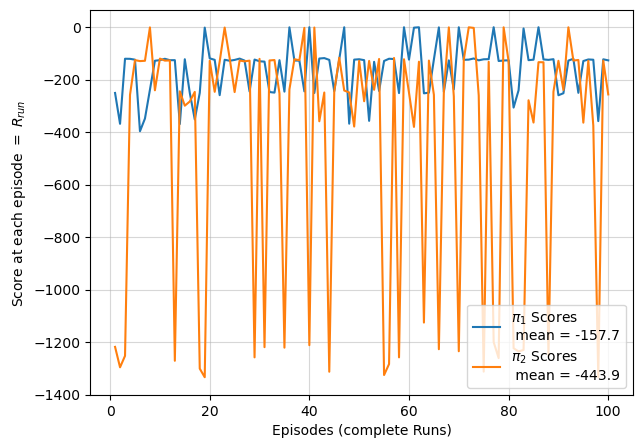

π₁ → length 200, total reward -123.5, last reward -0.0
π₂ → length 200, total reward -878.2, last reward -0.9
Collected 200 preference pairs.
Epoch 0: DPO Loss = 3.782088e+02


In [ ]:
seeds_list=[42] #100 35
for seed in seeds_list:
    # Choose environment:

    # env 2: 
    env_name= 'Pendulum-v1'
    torch.manual_seed(seed)

    reward_threshold_pi1 = -140
    reward_threshold_pi2 = -500 #TODO ev- augmenter

    load_policies = True # USe True if policies have benn trained already
    
    # ── Hyperparams for sac ── See defaults in the code
    lr_SAC = 1e-3 # learning rate for SAC
    n_episodes              = 100 # keep same “number of iterations” for fair comparison
    TIMESTEPS               = 500  # cap on steps per episode
    print_every             = 1   # print every x episodes and avg also the score for every x episodes
    # gamma                   = 0.99

    seed_training_policies  = seed


    # ── Instantiate the two policies & optimizers for SAC ──
    # env_SAC   = gym.make(env_name)
    env_SAC = DummyVecEnv([lambda: TwoTensorReset(gym.make("Pendulum-v1"))])
    model = SAC(policy="MlpPolicy", env=env_SAC,learning_rate=lr_SAC, verbose=0)    



    # ── Run the SAC training ──
    if not load_policies:

        # Training the policy:
        for i in range(n_episodes):
            model.learn(total_timesteps=TIMESTEPS,reset_num_timesteps=False)
        
            if i % 1 == 0:
                mean_reward, std_reward, epsisode_rewards = evaluate_policy_sac(
                    model,
                    env_SAC,
                    n_eval_episodes=100,
                    deterministic=True,
                )
                print(f" at update {i}: Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
                if mean_reward > reward_threshold_pi2 and mean_reward < reward_threshold_pi2+ 150:
                    print(f"Saving model pi2 at {mean_reward}")
                    # model.save(f"{models_dir}/pi2-{TIMESTEPS*i}")
                    model.save(f"pi2_SAC_{env_name}_seed_{seed}") 
                elif mean_reward > reward_threshold_pi1:
                    print(f"Saving model pi1 at {mean_reward}")
                    # model.save(f"{models_dir}/pi1-{TIMESTEPS*i}")
                    model.save(f"pi1_SAC_{env_name}_seed_{seed}") 
                    break
   
        # ── Load the policies ──
    # ── Load trained SAC models ─────────────────────────────────────
    model1 = SAC.load(f"pi1_SAC_{env_name}_seed_{seed}",
                    env=env_SAC,
                    device=device)
    model2 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}",
                    env=env_SAC,
                    device=device)

    pi1_SAC = model1.policy        # ← this is a SACPolicy, already initialised
    pi2_SAC = model2.policy
    


    # ── Create trajectories ──
    # Hperparameters for DPO
    num_episodes = 100
    K = 200
    beta = 0.5

    pi1_mean_reward, std_reward1, pi1_reward = evaluate_policy_sac(pi1_SAC, env_SAC, n_eval_episodes=num_episodes)
    pi2_mean_reward, std_reward2, pi2_reward = evaluate_policy_sac(pi2_SAC, env_SAC, n_eval_episodes=num_episodes)
    print("Evaluations over", num_episodes, "episodes done for both policies")

    # plot_suboptimality(
    #     pi1_reward,
    #     pi2_reward,
    #     max_reward=0,
    # )

    plot_Scores(
        pi1_reward,
        pi2_reward,
    )
    traj1 = generate_trajectory(pi1_SAC, env_SAC, max_steps=200)
    traj2 = generate_trajectory(pi2_SAC, env_SAC, max_steps=200)

    print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}, last reward {traj1[-1]['reward']:.1f}")
    print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}, last reward {traj2[-1]['reward']:.1f}")
    # K=10
    prefs = sample_preference_pairs(pi1_SAC, pi2_SAC, env_SAC, K=K) # Need to define K elsewhere as hyperparameter
    print(f"Collected {len(prefs)} preference pairs.")
    lr_DPO=0.01

    # extract their policies
    model4 = SAC.load(f"pi1_SAC_{env_name}_seed_{seed}",
                    env=env_SAC,
                    device=device)
    model5 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}",
                    env=env_SAC,
                    device=device)
    policy_ref = model4.policy          # reference π_ref
    policy_DPO = model5.policy          # the one we will fine-tune with DPO

    # (optional but recommended) freeze critics so we only update the actor
    for p in policy_DPO.critic.parameters():
        p.requires_grad = False

    # optimiser on the *actor* parameters only
    opt_DPO = torch.optim.Adam(policy_DPO.actor.parameters(), lr=lr_DPO)

    # run DPO 
    # beta = 0.5
    DPO_training(policy_DPO, policy_ref, prefs, beta,
                opt_DPO, nb_epochs=400)
    # after DPO fine-tuning is finished
    # model_DPO = SAC(policy="MlpPolicy", env=env_SAC,learning_rate=lr_SAC, verbose=0)   
    policy_DPO.save(f"pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}")
    print(f"Saved final policy as pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}")

    num_episodes = 100
    pi1_mean_reward, std_reward1, pi1_reward = evaluate_policy_sac(policy_DPO, env_SAC, n_eval_episodes=num_episodes)
    pi2_mean_reward, std_reward2, pi2_reward = evaluate_policy_sac(policy_ref, env_SAC, n_eval_episodes=num_episodes)

    # plot_suboptimality(
    #     pi1_reward,
    #     pi2_reward,
    #     0,
    # )  

    plot_Scores(
        pi1_reward,
        pi2_reward,
    )



Averaging over the different seeds

In [ ]:
file_pi1=[f"pi1_SAC_{env_name}_seed_{seed}"]
file_pi2=[f"pi2_SAC_{env_name}_seed_{seed}"]
file_pi_DPO=[f"pi_DPO_SAC_{env_name}_seed_{seed}",f"pi_DPO_SAC_{env_name}_seed_{seed}_K200",f"pi_DPO_SAC_{env_name}_seed_{seed}_beta0.005",f"pi_DPO_SAC_{env_name}_seed_{seed}_beta1_invverted"]

import torch
import numpy as np
import os

def load_policy(file_path, env, device="cpu"):
    """
    Pass *base* path; SB3 will add '.zip' automatically if needed.
    """
    # strip .pth or .zip if user supplied one
    file_base = os.path.splitext(file_path)[0]
    model = SAC.load(file_base, env=env, device=device)
    return model.policy

# def load_policy(path, env, device="cpu"):
#     model = SAC.load(path, env=env, device=device)   # SB3 appends ".zip"
#     return model.policy


In [ ]:
def evaluate_all_policies(env, seeds, env_name, num_episodes=10, device="cpu"):
    """
    Expect checkpoints saved with  SB3 model.save("<base-name>")
    which creates the file  "<base-name>.zip".
    We pass *base names* everywhere; load_policy() appends ".zip" for us.
    """
    results = {}

    # ========== π1 / π2 (one file per seed) ==========
    for label in ["pi1", "pi2"]:
        returns, rewards_acc = [], np.zeros(num_episodes)
        for seed in seeds:
            base = f"{label}_SAC_{env_name}_seed_{seed}"
            if not os.path.exists(base + ".zip"):
                print("Missing:", base + ".zip")
                continue

            policy = load_policy(base, env, device)
            mean_ret, std_ret, r_per_ep = evaluate_policy_sac(policy, env,
                                                 n_eval_episodes=num_episodes)
            returns.append(mean_ret)
            rewards_acc += r_per_ep

        if returns:   # avoid div-by-zero if all files missing
            results[label] = {
                "mean": float(np.mean(returns)),
                "std":  float(np.std(returns)),
                "per_seed": returns,
                "graph": rewards_acc / len(returns),
            }

    # ========== DPO variants (suffixes) ===============
    suffixes = ["", "_K200", "_beta0.005", "_beta0.5_K10", "_beta1_inverted"]

    for suffix in suffixes:
        key          = f"pi_DPO{suffix or '_base'}"
        returns, rewards_acc = [], np.zeros(num_episodes)

        for seed in seeds:
            base = f"pi_DPO_{env_name}_seed_{seed}{suffix}"
            if not os.path.exists(base + ".zip"):       #Can get rid of .zip? TODO
                print("Missing:", base + ".zip")
                continue

            policy = load_policy(base, env, device)
            mean_ret, std_ret, r_per_ep = evaluate_policy_sac(policy, env,
                                                 n_eval_episodes=num_episodes)
            returns.append(mean_ret)
            rewards_acc += r_per_ep

        if returns:
            results[key] = {
                "mean": float(np.mean(returns)),
                "std":  float(np.std(returns)),
                "per_seed": returns,
                "graph": rewards_acc / len(returns),
            }

    return results


In [ ]:
results=evaluate_all_policies(env_SAC,seeds_list,env_name,50)

C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# show what keys we actually have
print("Available keys:", list(results.keys()))

# π₂ is “initial” (what you called ‘init’), π₁ is “reference”
reward_hist_init = results["pi2"]["graph"]
reward_hist_ref  = results["pi1"]["graph"]

# these are the exact DPO keys that evaluate_all_policies creates:
dpo_keys = [
    "pi_DPO_base",          # the plain file
    "pi_DPO_K200",
    "pi_DPO_beta0.005",
    "pi_DPO_beta0.5_K10",
    "pi_DPO_beta1_inverted",
]

for key in dpo_keys:
    if key not in results:
        print(f"Skipping missing key {key!r}")
        continue

    reward_hist_dpo = results[key]["graph"]
    print(f"\nPlotting {key!r}")
    plot_suboptimality_three_policies(
        reward_hist_dpo,
        reward_hist_init,
        reward_hist_ref,
        max_reward=0   # adjust for Pendulum
    )



Available keys: ['pi1', 'pi2']
Skipping missing key 'pi_DPO_base'
Skipping missing key 'pi_DPO_K200'
Skipping missing key 'pi_DPO_beta0.005'
Skipping missing key 'pi_DPO_beta0.5_K10'
Skipping missing key 'pi_DPO_beta1_inverted'


In [ ]:
# # Example labels: 'pi_DPO_', 'pi1', 'pi2'
# max_reward = 0
# print(results.keys())
# reward_hist_init = results["pi2"]["graph"]
# reward_hist_ref = results["pi1"]["graph"]
# reward_hist_dpo = results["pi_DPO_pi_DPO_Pendulum-V1_seed_35"]["graph"]

# plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)

# reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_K200"]["graph"]

# plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)
# reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.005"]["graph"]

# plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)
# reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.5_K10"]["graph"]

# plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)


# reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta1_inverted"]["graph"]
# reward_hist_init = results["pi1"]["graph"]
# reward_hist_ref = results["pi2"]["graph"]
# plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)